In [11]:
from scripts import parse_timeloop_output
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt

In [12]:
# Returns total area & key/value array of area breakdown
def area_from_ART(filename):
    with open(filename, "r") as stream:
        try:
            kva = yaml.safe_load(stream)['ART']['tables']
            total_area = sum([kv['area'] for kv in  kva ])
            return total_area, kva
        except yaml.YAMLError as ex:
            print(ex)

# Eyerissv2-like bidirectional bitmask skipping

In [13]:
# Baseline raw metrics
eyerisslike_bidir_bitmask_skipping_baseline = parse_timeloop_output.parse_timeloop_stats('eyerissv2_bidir_bitmask/output/timeloop-model.map+stats.xml')
energy_pJ_baseline = float(eyerisslike_bidir_bitmask_skipping_baseline['energy_pJ'])
cycles_baseline = float(eyerisslike_bidir_bitmask_skipping_baseline['cycles'])
area_baseline, kva_baseline = area_from_ART('eyerissv2_bidir_bitmask/output/timeloop-model.ART.yaml')
# Raw metrics with SAF
eyerisslike_bidir_bitmask_skipping_saftool = parse_timeloop_output.parse_timeloop_stats('eyerissv2_bidir_bitmask/output_w_SAF/timeloop-model.map+stats.xml')
energy_pJ_saftool = float(eyerisslike_bidir_bitmask_skipping_saftool['energy_pJ'])
cycles_saftool = float(eyerisslike_bidir_bitmask_skipping_saftool['cycles'])
area_saftool, kva_saftool = area_from_ART('eyerissv2_bidir_bitmask/output_w_SAF/timeloop-model.ART.yaml')

## Summary of SAF uarch overhead impact on energy/area

In [14]:
# initialize data of lists.
data = {'Name': ['Eyerissv2-like ideal SAFs', 'Eyerissv2 w/ SAF uarch'],
        'Inference energy (pJ)': [energy_pJ_baseline, energy_pJ_saftool],
        'cycles': [cycles_baseline, cycles_saftool],
        'area (umm^2)': [area_baseline,area_saftool]}
  
# Create DataFrame
df = pd.DataFrame(data)
  
# Print the output.
df

,Name,Inference energy (pJ),cycles,area (umm^2)
0,Eyerissv2-like ideal SAFs,1.583402e+07,1592245.0,6018.9675
1,Eyerissv2 w/ SAF uarch,7.062020e+07,1592245.0,9320.0237


## Breakdown

In [15]:
is_ocm = lambda x: (not("MAC" in x['name'])) and (not("mac" in x['name'])) and (not ("BackingStorage" in x['name']))
is_arith = lambda x: ("MAC" in x['name']) or ("mac" in x['name'])

In [16]:
# Baseline breakdown

ocm_baseline_components = [kv['name'] for kv in kva_baseline if is_ocm(kv)]
mac_baseline_components = [kv['name'] for kv in kva_baseline if is_arith(kv)]
ocm_baseline_area = sum([kv['area'] for kv in kva_baseline if kv['name'] in ocm_baseline_components])
mac_baseline_area = sum([kv['area'] for kv in kva_baseline if kv['name'] in mac_baseline_components])

# Breakdown with SAF uarch overhead

ocm_saftool_components = [kv['name'] for kv in kva_saftool if is_ocm(kv)]
mac_saftool_components = [kv['name'] for kv in kva_saftool if is_arith(kv)]
ocm_saftool_area = sum([kv['area'] for kv in kva_saftool if kv['name'] in ocm_saftool_components])
mac_saftool_area = sum([kv['area'] for kv in kva_saftool if kv['name'] in mac_saftool_components])
safuarch_saftool_area = (ocm_saftool_area - ocm_baseline_area) + (mac_saftool_area - mac_baseline_area)

print('Baseline OCM area (um^2): ', ocm_baseline_area, 'OCM components: ', ocm_baseline_components)
print('SAFtools OCM area (um^2): ', ocm_saftool_area, 'OCM components: ', ocm_saftool_components)
print('SAFtools SAF uarch area (um^2): ', safuarch_saftool_area)
print('Baseline Arithmetic area (um^2): ', mac_baseline_area, 'Arithmetic components: ', mac_baseline_components)
print('SAFtools Arithmetic area (um^2): ', mac_saftool_area, 'Arithmetic components: ', mac_saftool_components)

# initialize data of lists.
data = {'Modeling': ['No SAFuarch modeling', 'w/ SAFuarch modeling'],
        'OCM area (um^2)': [ocm_baseline_area, ocm_baseline_area],
        'SAFuarch area (um^2)': [0.0, safuarch_saftool_area],
        'Arithmetic (um^2)': [mac_baseline_area,mac_baseline_area]}
data['Total (um^2)'] = [(data['OCM area (um^2)'][0]+data['SAFuarch area (um^2)'][0]+data['Arithmetic (um^2)'][0]),
                        (data['OCM area (um^2)'][1]+data['SAFuarch area (um^2)'][1]+data['Arithmetic (um^2)'][1])]

data_pct = {'Modeling': ['No SAFuarch modeling', 'w/ SAFuarch modeling'],
            'OCM area (%)':[100.0*data['OCM area (um^2)'][0]/data['Total (um^2)'][0],
                            100.0*data['OCM area (um^2)'][1]/data['Total (um^2)'][1]],
            'SAFuarch area (%)':[100.0*data['SAFuarch area (um^2)'][0]/data['Total (um^2)'][0],
                                 100.0*data['SAFuarch area (um^2)'][1]/data['Total (um^2)'][1]],
            'Arithmetic (%)':[100.0*data['Arithmetic (um^2)'][0]/data['Total (um^2)'][0],
                                 100.0*data['Arithmetic (um^2)'][1]/data['Total (um^2)'][1]]                                 }


# Create DataFrame
df = pd.DataFrame(data)
df.style.set_caption('Eyerissv2-like bidirectional bitmask skipping: PE area breakdown in um^2')
df_pct = pd.DataFrame(data_pct)
df_pct.style.set_caption('Eyerissv2-like bidirectional bitmask skipping: PE area breakdown in %')
  
# Print the output.
display(df)
display(df_pct)

Baseline OCM area (um^2):  5686.717500000001 OCM components:  ['eyeriss_v2_PE.PE.psum_spad', 'eyeriss_v2_PE.PE.iact_spad', 'eyeriss_v2_PE.PE.weight_spad', 'eyeriss_v2_PE.PE.reg']
SAFtools OCM area (um^2):  8987.7737 OCM components:  ['eyeriss_v2_PE.PE.psum_spad', 'eyeriss_v2_PE.PE.iact_spad', 'eyeriss_v2_PE.PE.weight_spad', 'eyeriss_v2_PE.PE.reg']
SAFtools SAF uarch area (um^2):  3301.056199999999
Baseline Arithmetic area (um^2):  332.25 Arithmetic components:  ['eyeriss_v2_PE.PE.MAC']
SAFtools Arithmetic area (um^2):  332.25 Arithmetic components:  ['eyeriss_v2_PE.PE.MAC']


,Modeling,OCM area (um^2),SAFuarch area (um^2),Arithmetic (um^2),Total (um^2)
0,No SAFuarch modeling,5686.7175,0.0000,332.25,6018.9675
1,w/ SAFuarch modeling,5686.7175,3301.0562,332.25,9320.0237


,Modeling,OCM area (%),SAFuarch area (%),Arithmetic (%)
0,No SAFuarch modeling,94.479950,0.000000,5.520050
1,w/ SAFuarch modeling,61.016127,35.418968,3.564905


([<matplotlib.patches.Wedge at 0x147495010>,
 [Text(-1.0835009076306448, 0.18980459205079578, 'OCM area'),
  Text(1.0835008943025508, -0.18980466813430333, 'Arithmetic area')])

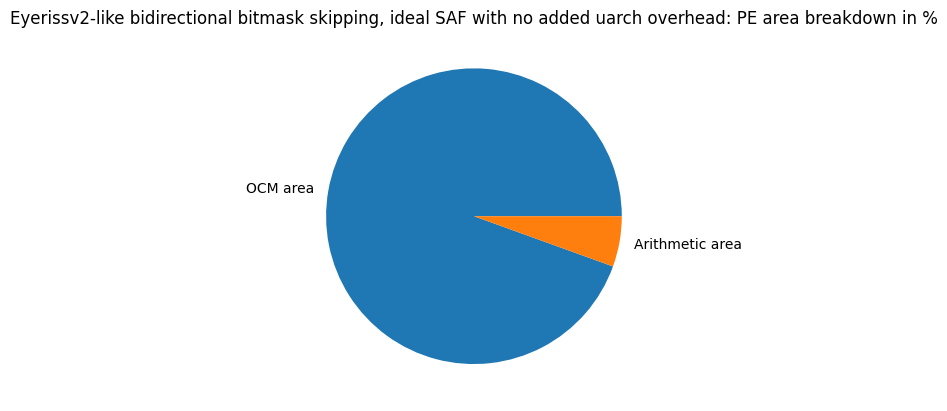

In [17]:
labels = 'OCM area', 'Arithmetic area'
sizes = [data_pct['OCM area (%)'][0], data_pct['Arithmetic (%)'][0]]

fig, ax = plt.subplots()
plt.title('Eyerissv2-like bidirectional bitmask skipping, ideal SAF with no added uarch overhead: PE area breakdown in %')
ax.pie(sizes, labels=labels)

([<matplotlib.patches.Wedge at 0x1477ef950>,
 [Text(-0.3731361379202198, 1.0347798908840387, 'OCM area'),
  Text(0.255150805844104, -1.0699990963907888, 'SAFuarch area'),
  Text(1.0931086864214474, -0.12293656766795684, 'Arithmetic area')])

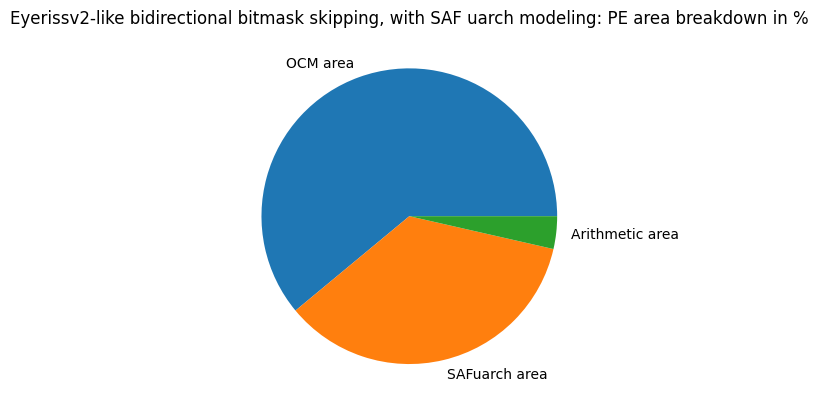

In [18]:
labels = 'OCM area', 'SAFuarch area', 'Arithmetic area'
sizes = [data_pct['OCM area (%)'][1], data_pct['SAFuarch area (%)'][1], data_pct['Arithmetic (%)'][1]]

fig, ax = plt.subplots()
plt.title('Eyerissv2-like bidirectional bitmask skipping, with SAF uarch modeling: PE area breakdown in %')
ax.pie(sizes, labels=labels)

In [19]:
# fig = plt.figure(figsize = (8, 2))
# ax = fig.add_subplot(111)

# ax.table(cellText = df.values,
#           rowLabels = df.index,
#           colLabels = df.columns,
#           loc = "center"
#          )
# ax.set_title("Eyerissv2-like bidirectional bitmask skipping: PE area breakdown in um^2")

# ax.axis("off");